In [1]:
from model import MyFasterRCNN
from data import BedsoreDataModule
from utils import batch2pil, draw_bbox, out2detfile
from matplotlib import pyplot as plt
import os
from PIL import Image
import numpy as np

In [2]:
dm = BedsoreDataModule(root='data', num_valid=100, batch_size=1, trans_prob=0.5)
ds = dm.test_dataloader().dataset
model = MyFasterRCNN.load_from_checkpoint('mlruns/0/6a4db3213ff54cee864d6aea0d6eb782/checkpoints/epoch=56.ckpt')
net = model.net
net.eval()
pass

/home/zrway/anaconda3/lib/python3.7/site-packages/albumentations/pytorch/transforms.py:58: DeprecationWarning: ToTensor is deprecated and will be replaced by ToTensorV2 in albumentations 0.5.0
  "ToTensor is deprecated and will be replaced by ToTensorV2 " "in albumentations 0.5.0", DeprecationWarning


B01_00027
gt: tensor([6])


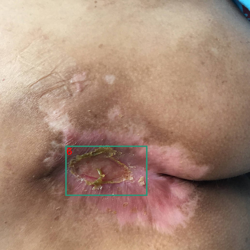

In [64]:
SZ = 250
idx = 84
image,target = ds[idx]
print(target['fname'])
print('gt:',target['labels'])
draw_bbox(image,target).resize((SZ,SZ))

out labels:  tensor([2, 1, 9, 2, 3, 9, 2, 6])
out scores:  tensor([0.9577, 0.5037, 0.4619, 0.3465, 0.0815, 0.0790, 0.0700, 0.0669])


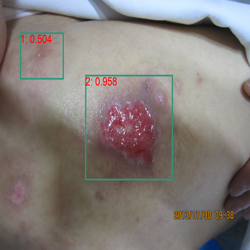

In [63]:
out = net([image],[target])[0]
print('out labels: ', out['labels'])
print('out scores: ', out['scores'].detach())
draw_bbox(image,out).resize((SZ,SZ))

### Batch Eval 计算分数

In [1]:
from model import MyFasterRCNN
from data import BedsoreDataModule
from utils import batch2pil, draw_bbox, out2detfile
from matplotlib import pyplot as plt
from tqdm import tqdm
import voc_eval
import os

detpath = 'temp/det_outs.txt'
imgsetfile = 'temp/evallist.txt'

In [3]:
dm = BedsoreDataModule(root='data', num_valid=100, batch_size=1,trans_prob=0.5)
ds = dm.val_dataloader().dataset
model = MyFasterRCNN.load_from_checkpoint('mlruns/0/40eb48da3c844db9afc77346b7d1d29f/checkpoints/epoch=18.ckpt')
net = model.net
net.eval()
pass

/home/zrway/anaconda3/lib/python3.7/site-packages/albumentations/pytorch/transforms.py:58: DeprecationWarning: ToTensor is deprecated and will be replaced by ToTensorV2 in albumentations 0.5.0
  "ToTensor is deprecated and will be replaced by ToTensorV2 " "in albumentations 0.5.0", DeprecationWarning


In [4]:
# 预测
outs = []
for image,target in tqdm(ds):
    out = net([image],[target])[0]
    outs += out2detfile(target,out)        

  0%|          | 0/100 [00:00<?, ?it/s]/home/zrway/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:3103: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
100%|██████████| 100/100 [03:23<00:00,  2.03s/it]


In [5]:
# 将检测结果写入文件
os.remove(detpath)
for i in outs:
    with open(detpath,'a+') as f:
        f.write(i)

In [6]:
# 预测文件列表

os.remove(imgsetfile)
for _,target in ds:
    fname= target['fname']
    with open(imgsetfile,'a+') as f:
        f.write(fname +'\n')

In [7]:
voc_eval.voc_eval(detpath,
                  'data/VOCdevkit/VOC2007/Annotations/{}.xml',
                  imgsetfile,
                  '深部组织损伤',
                  ovthresh=0.3,
                  use_07_metric=True)

(array([0.09090909, 0.18181818, 0.27272727, 0.36363636, 0.45454545,
        0.54545455, 0.63636364, 0.72727273, 0.72727273, 0.72727273,
        0.72727273, 0.72727273, 0.72727273, 0.72727273, 0.72727273,
        0.72727273, 0.72727273]),
 array([1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 0.88888889, 0.8       ,
        0.72727273, 0.66666667, 0.61538462, 0.57142857, 0.53333333,
        0.5       , 0.47058824]),
 0.7272727272727274)

In [8]:
tissus_name = ['1期','2期','3期','4期','不可分期','深部组织损伤']
mAP = []
for i in tissus_name:
    ap = voc_eval.voc_eval(detpath,
                  'data/VOCdevkit/VOC2007/Annotations/{}.xml',
                  imgsetfile,
                  i,
                  ovthresh=0.3,
                  use_07_metric=True)[-1]
    print(ap)
    mAP.append(ap)
sum(mAP)/len(mAP)

0.0
0.4418081918081918
0.5099206349206349
0.7665188470066518
0.5867965367965369
0.7272727272727274


0.5053861563007905